In [2]:
import pandas as pd

# Loading datasets
accepted_df = pd.read_csv('../data/accepted.csv')
rejected_df = pd.read_csv('../data/rejected.csv')

# Preview of each dataset
print("Accepted loans shape:", accepted_df.shape)
print("Rejected loans shape:", rejected_df.shape)

print("\nAccepted loans sample:")
print(accepted_df.head())

print("\nRejected loans sample:")
print(rejected_df.head())

/var/folders/xz/lff41jfs2n51nmclpq2gml6c0000gn/T/ipykernel_47272/3336764915.py:4: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv('../data/accepted.csv')


Accepted loans shape: (2260701, 151)
Rejected loans shape: (27648741, 9)

Accepted loans sample:
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91    

In [4]:
# Check for missing values

missing_summary = accepted_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(accepted_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percent Missing': missing_percent
})

# View top 30 columns with most missing values
missing_df.head(30)


,Missing Values,Percent Missing
member_id,2260701,100.000000
orig_projected_additional_accrued_interest,2252050,99.617331
hardship_end_date,2249784,99.517097
hardship_start_date,2249784,99.517097
hardship_type,2249784,99.517097
hardship_reason,2249784,99.517097
hardship_status,2249784,99.517097
deferral_term,2249784,99.517097
hardship_last_payment_amount,2249784,99.517097
hardship_payoff_balance_amount,2249784,99.517097


In [5]:
# Drop columns with more than 60% missing values
high_missing_cols = missing_df[missing_df['Percent Missing'] > 60].index.tolist()
accepted_df = accepted_df.drop(columns=high_missing_cols)

# Drop identifier and non-informative columns
columns_to_remove = ['id', 'member_id', 'url', 'desc', 'title', 'zip_code']
accepted_df = accepted_df.drop(columns=columns_to_remove, errors='ignore')

# Remaining shape
print("Remaining shape after dropping:", accepted_df.shape)

Remaining shape after dropping: (2260701, 105)


In [8]:
# Clean target variable
accepted_df['loan_status'].value_counts()

# Keep only Fully Paid and Charged Off
accepted_df = accepted_df[accepted_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Create target column
accepted_df['loan_status_binary'] = accepted_df['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1
})

# Confirm target value counts
accepted_df['loan_status_binary'].value_counts(normalize=True)

if accepted_df['term'].dtype == 'object':
    accepted_df['term'] = accepted_df['term'].str.extract(r'(\d+)').astype(float)

# Clean 'int_rate' column
if accepted_df['int_rate'].dtype == 'object':
    accepted_df['int_rate'] = accepted_df['int_rate'].str.replace('%', '', regex=False).astype(float)

# Clean 'emp_length' column
if accepted_df['emp_length'].dtype == 'object':
    accepted_df['emp_length'] = accepted_df['emp_length'].str.extract(r'(\d+)')
    accepted_df['emp_length'] = pd.to_numeric(accepted_df['emp_length'], errors='coerce')

# Check updated types
accepted_df[['term', 'int_rate', 'emp_length']].dtypes

term          float64
int_rate      float64
emp_length    float64
dtype: object

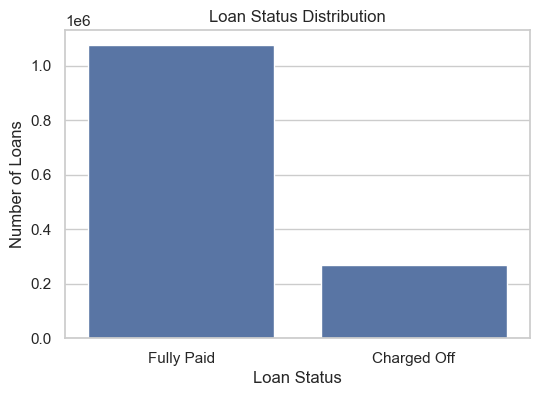

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status_binary', data=accepted_df)
plt.xticks([0, 1], ['Fully Paid', 'Charged Off'])
plt.title("Loan Status Distribution")
plt.xlabel("Loan Status")
plt.ylabel("Number of Loans")
plt.show()


In [10]:
# Select numeric features only
numeric_cols = accepted_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation with the binary loan status target
correlations = accepted_df[numeric_cols].corr()['loan_status_binary'].drop('loan_status_binary')
correlations_sorted = correlations.sort_values(key=abs, ascending=False)

# Show top 15
print(correlations_sorted.head(15))


last_fico_range_high      -0.667842
last_fico_range_low       -0.575706
recoveries                 0.505415
collection_recovery_fee    0.480216
total_rec_prncp           -0.438944
last_pymnt_amnt           -0.347385
total_pymnt               -0.315180
total_pymnt_inv           -0.314751
int_rate                   0.258792
term                       0.176096
total_rec_late_fee         0.141032
fico_range_low            -0.130683
fico_range_high           -0.130682
acc_open_past_24mths       0.099869
all_util                   0.089014
Name: loan_status_binary, dtype: float64


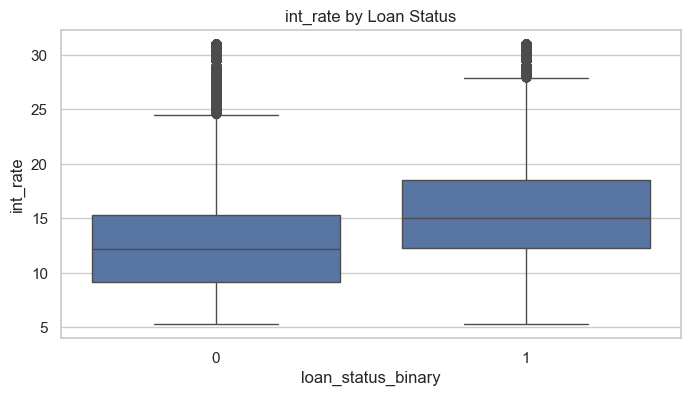

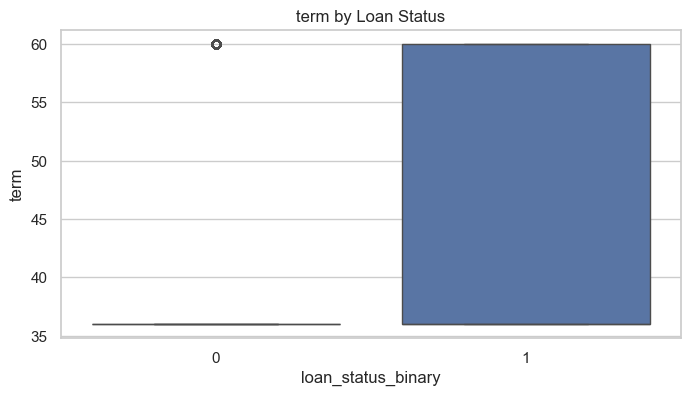

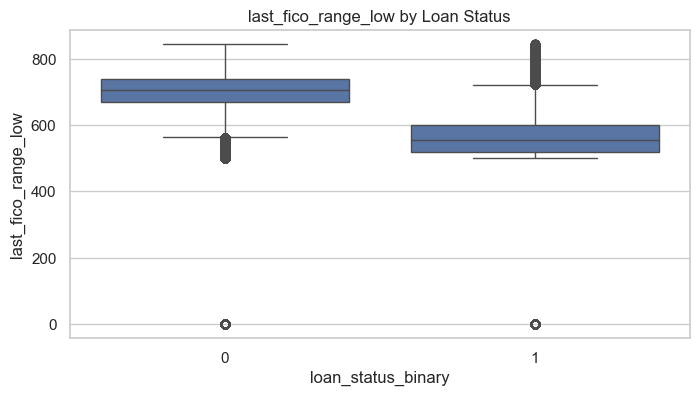

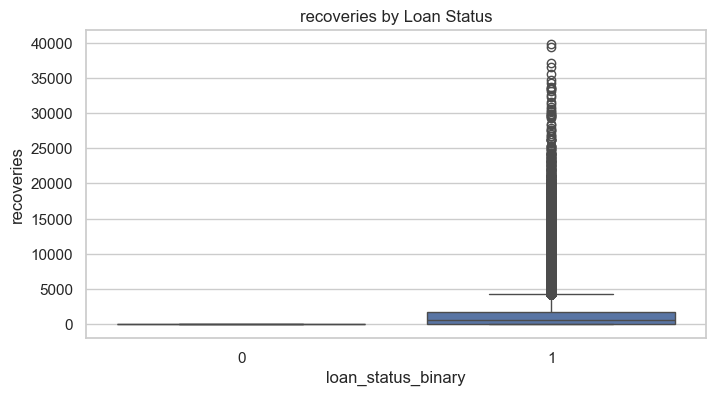

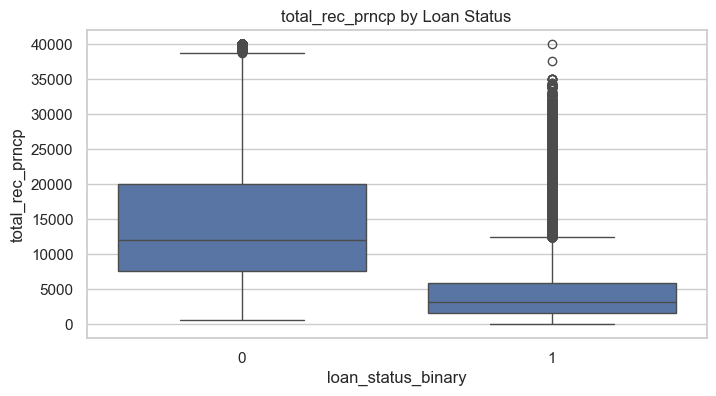

In [11]:
features_to_plot = ['int_rate', 'term', 'last_fico_range_low', 'recoveries', 'total_rec_prncp']

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='loan_status_binary', y=feature, data=accepted_df)
    plt.title(f'{feature} by Loan Status')
    plt.show()


In [13]:
# Drop outcome-dependent features
leak_cols = [
    'recoveries',
    'collection_recovery_fee',
    'total_rec_prncp',
    'total_pymnt',
    'total_pymnt_inv',
    'last_pymnt_amnt',
    'loan_status'
]

accepted_df = accepted_df.drop(columns=leak_cols, errors='ignore')


In [14]:
# Check remaining object columns
accepted_df.select_dtypes(include='object').columns.tolist()

accepted_df = pd.get_dummies(accepted_df, columns=['grade', 'home_ownership', 'purpose'], drop_first=True)


In [15]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = accepted_df.drop(columns=['loan_status_binary'])
y = accepted_df['loan_status_binary']

# Train/test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (1076248, 119)
Test set shape: (269062, 119)
